# Interactions between ProTα and Histone H1.0

In [2]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Templates

In [7]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'ProTa': 'P06454',
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [8]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

In [9]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
ProTa,P06454,PTMA_HUMAN,Prothymosin alpha,Homo sapiens (Human),MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...


In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Data

In [9]:
# Getting template metadata
with open('prota_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [12]:
# Getting IDR of H1.0 (C-terminal IDR)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['H1-0']['uniprot_id'], i_idr=-1, length_order=False)
H10 = {'template': 'H1-0', 'sequence': seq, 'location': loc, 'region': 'CTD', 'variant': 'Wild type'}

# Getting IDR of ProTa (Full-length IDP)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['ProTa']['uniprot_id'], i_idr=-1, length_order=True)
ProTa = {'template': 'ProTa', 'sequence': seq, 'location': loc, 'region': 'FL', 'variant': 'Wild type'}

In [13]:
# Assembling all data entries for simulation
data = pd.DataFrame([H10, ProTa], index = ['H1-0_WT', 'ProTa_WT'])
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
ProTa_WT,ProTa,MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...,0:111,FL,Wild type


In [14]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [16]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Topologies

#### Compact frames

In [ ]:
# Getting compact frame topologies
cond = 'default'
trajs = {}

# Looping over proteins
for prot in ['PROTA_WT', 'H1-0_WT']:

    # Loading trajectory
    traj_path = f'results/single_chain/{cond}/{prot}/traj.dcd'
    top_path  = f'results/single_chain/{cond}/{prot}/top.pdb'

    # Selecting most compact frame
    compact_frame = analyse_utils.compact_frame(traj_path, top_path)
    trajs[prot] = compact_frame
trajs

In [ ]:
# Saving single topologies
for prot, traj in trajs.items():
    traj.save_pdb(f'data/{prot}.pdb')

#### Merging

In [18]:
# Loading trajectory
trajs = []
for prot in ['PROTA_WT', 'H1-0_WT']:
    top_path  = f'data/{prot}.pdb'
    trajs.append(md.load(top_path))
trajs

[<mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7f5388327730>,
 <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7f53883277f0>]

In [19]:
# Translating topologies
translate_x = 10 # nm
translate_y = 0 # nm
translate_z = 0 # nm
for i, traj in enumerate(trajs):
    traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [20]:
# Merging topologies
merged_traj = simulate_utils.merge_topologies(trajs, boxlength=25)

In [21]:
# Saving merged topologies
filename = 'data/H1-0_PROTA_WT_25nm.pdb'
merged_traj.save(filename)

# Identifying chains
simulate_utils.extract_sequences(filename).groupby('chain').q.sum(numeric_only=True)

chain
0    42
1   -44
Name: q, dtype: int64

## Analysis

### Two chain

#### $K_d$

In [ ]:
# Loading precalculated energy data
datas = []
resultsdir = "results/two_chain_25nm"
for condition in os.listdir(resultsdir):
    dir = f"{resultsdir}/{condition}/H1-0_PROTA_WT_25nm"
    data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
    data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
    data['condition'] = condition
    datas.append(data)
data = pd.concat(datas)
data

In [ ]:
# Calculating Kds
Kds = data.groupby('kappa').apply(lambda df: analyse_utils.compute_Kd(df['Total energy [kJ/mol]'], df['Center of mass distance [nm]'], 298, 100))

In [ ]:
# Assessing proper sampling
cutoff = 4
sampled = data.groupby('kappa').apply(lambda df: any(df['Minimum interresidue distance [nm]'] > cutoff))

#### Distance cutoffs for $K_d$

/tmp/ipykernel_16818/881686017.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='Min. distance')
/tmp/ipykernel_16818/881686017.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='Min. distance')
/tmp/ipykernel_16818/881686017.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='CoM distance')
/tmp/ipykernel_16818/881686017.py:8: Runtime

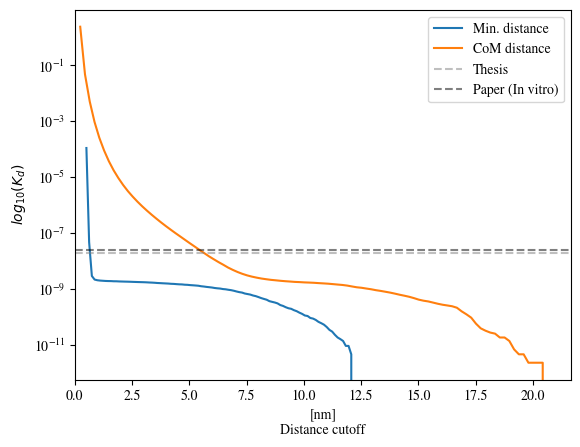

In [47]:
# Binning energy by collective variabl
state = data['Minimum interresidue distance [nm]']
cutoffs = np.linspace(min(state), max(state), 100)
plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='Min. distance')

state = data['Center of mass distance [nm]']
cutoffs = np.linspace(min(state), max(state), 100)
plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='CoM distance')

plt.xlim(0)
plt.hlines(Kd, *plt.xlim(), linestyles='--', color='grey', alpha=0.5, label='Thesis')
plt.hlines(25e-9, *plt.xlim(), linestyles='--', color='black', alpha=0.5, label='Paper (In vitro)')

plt.yscale('log')
plt.xlabel("[nm]\nDistance cutoff")
plt.ylabel('$log_{10}(K_d)$')
plt.legend()

### Three chain wild type ProTa - H1.0[CTD]

In [28]:
# Loading trajectories
top = "H1-0_2xPROTA_WT"
conds = ["default", "Borgia_in_silico", "ionic_165", "ionic_180", "ionic_205", "ionic_240", "ionic_290", "ionic_330", "ionic_340"]
charge_map = {
    42: 'H1-0 CTD',
    -44: 'ProTa'
}

# Loading trajectories and gathering sequence data
traj = {}
residues = {}
for cond in conds:
    dir = f"results/three_chain/{cond}/{top}"
    traj[cond] = md.load_dcd(f"{dir}/pretraj.dcd", f"{dir}/top.pdb")[1000:]
    residues[cond] = simulate_utils.extract_sequences(f"{dir}/top.pdb")
    

# Mapping chains by charge
chain_map = {}
for i, q in residues[conds[0]].groupby('chain').q.sum().items():
    chain_map[i] = charge_map[q]
for cond in conds:
    residues[cond]['chain_id'] = residues[cond]['chain'].map(chain_map)

dcdplugin) Warning: DCD header claims 14756 frames, file size indicates there are actually 14757 frames


In [30]:
# Centering trajectories around middle protein
for cond in conds:
    center_chain = 1
    chains = traj[cond].topology.find_molecules()
    assert len(chains) == 3, f"Topology for '{cond}' has wrong CONECT lines!"
    anchor_chain = [traj[cond].topology.find_molecules()[center_chain]]
    traj[cond].image_molecules(inplace=True, anchor_molecules=anchor_chain)

In [19]:
# Saving recentered trajs
for cond in conds:
    dir = f"results/three_chain/{cond}/{top}"
    traj[cond].save_dcd(f"{dir}/traj.dcd")

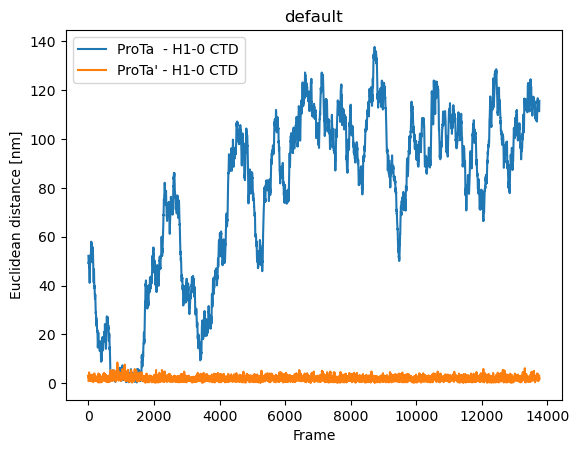

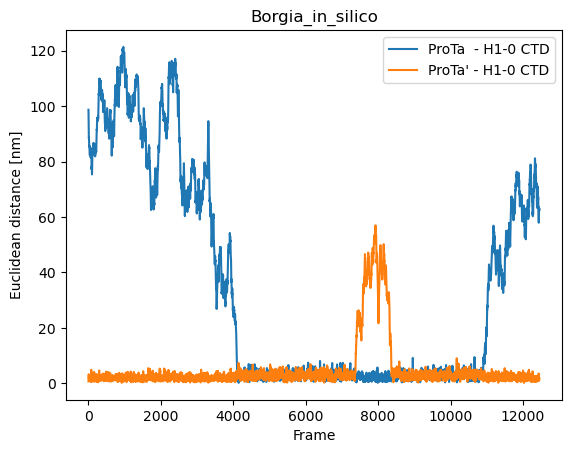

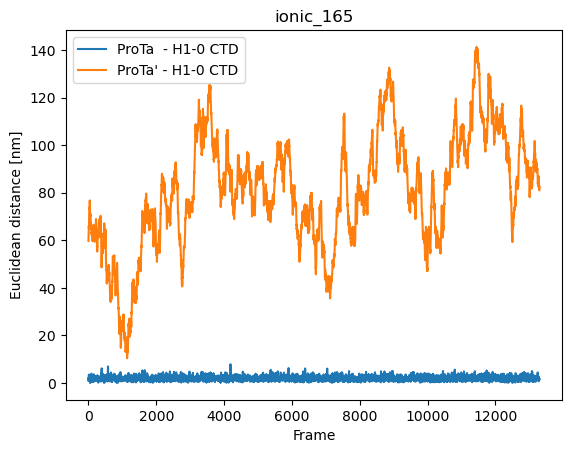

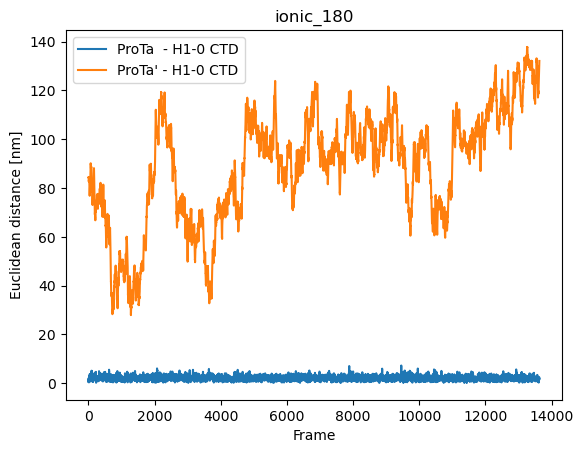

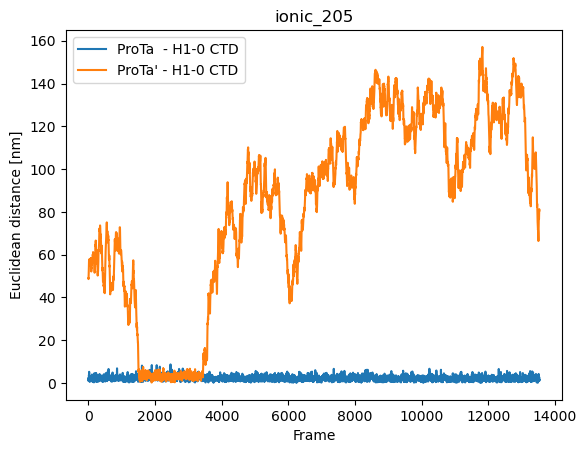

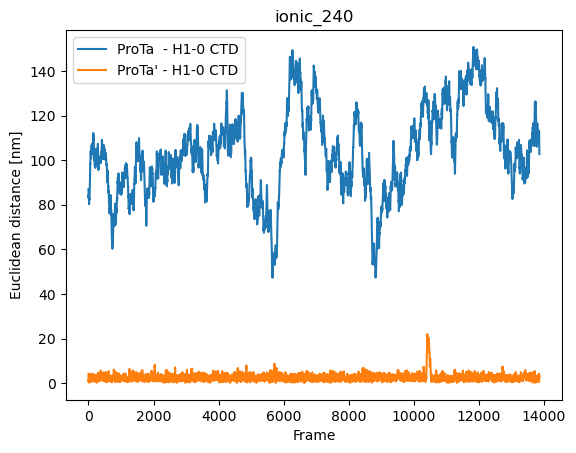

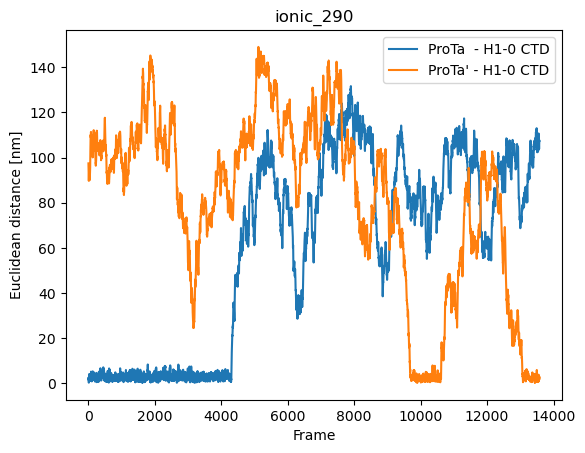

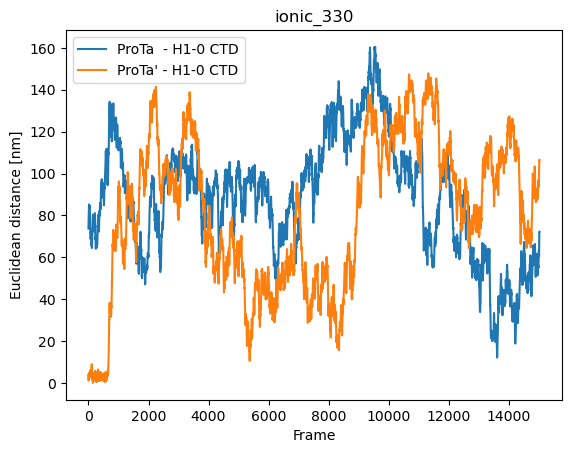

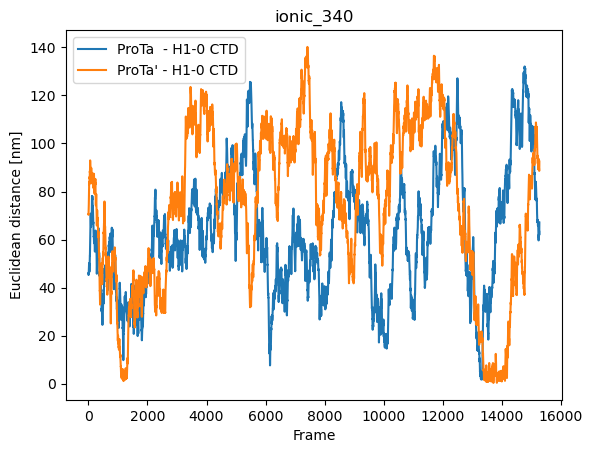

In [31]:
# Computing center of mass c
for cond in conds:
    c1 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 0]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 0]))
    c2 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 1]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 1]))
    c3 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 2]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 2]))
    com_diff_1 = (((c1-c2)**2).sum(axis=1))**0.5
    com_diff_2 = (((c3-c2)**2).sum(axis=1))**0.5
    plt.plot(com_diff_1, label=f"{chain_map[0]}  - {chain_map[1]}")
    plt.plot(com_diff_2, label=f"{chain_map[2]}' - {chain_map[1]}")
    plt.legend()
    plt.title(cond)
    plt.xlabel("Frame")
    plt.ylabel("Euclidean distance [nm]")
    plt.show()